<b>I tried the Multiple Instance Learning [1] method in this project. This method is very useful for weakly annotated data and tiled medical images.</b>

I have used the following methods.

* I used Gated Attention mechanism from the paper[2],
* Printing bags examples,
* 3 repetitive training steps (like 3-fold cross validation, but in this case we create new train and validation bags for each loop), at the end, averaging all the 3 loops test predictions
* Rectified and recreated functions in this notebook [3],
* Printing attention scores, 

 
<br>

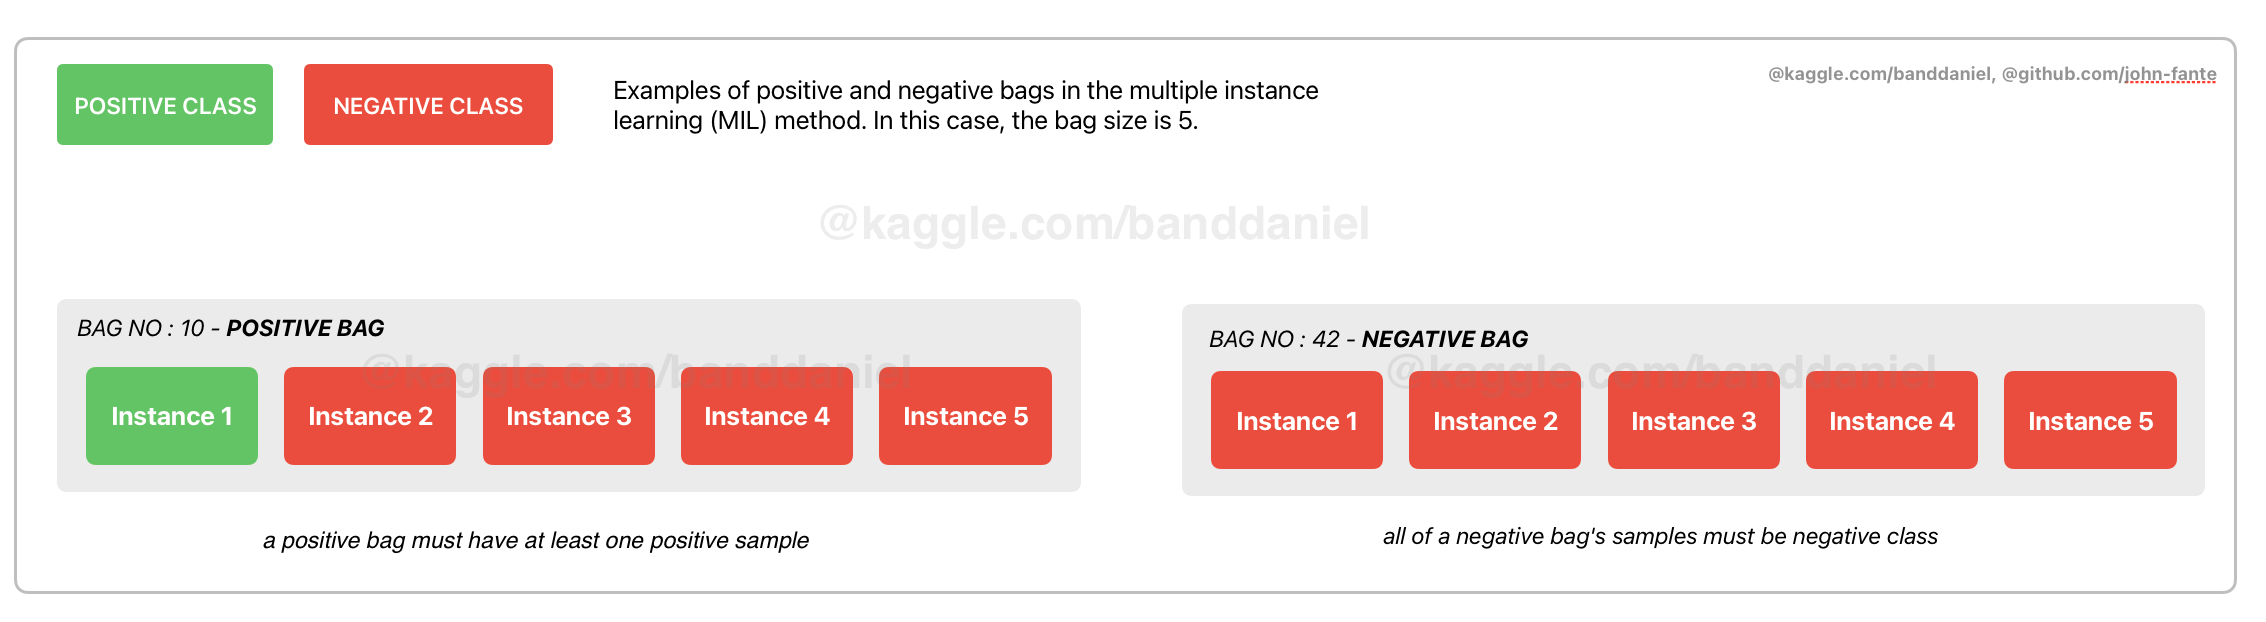
<i> <b>Figure 1:</b> Bags using in the Multiple Instance Learning</i>

<br>

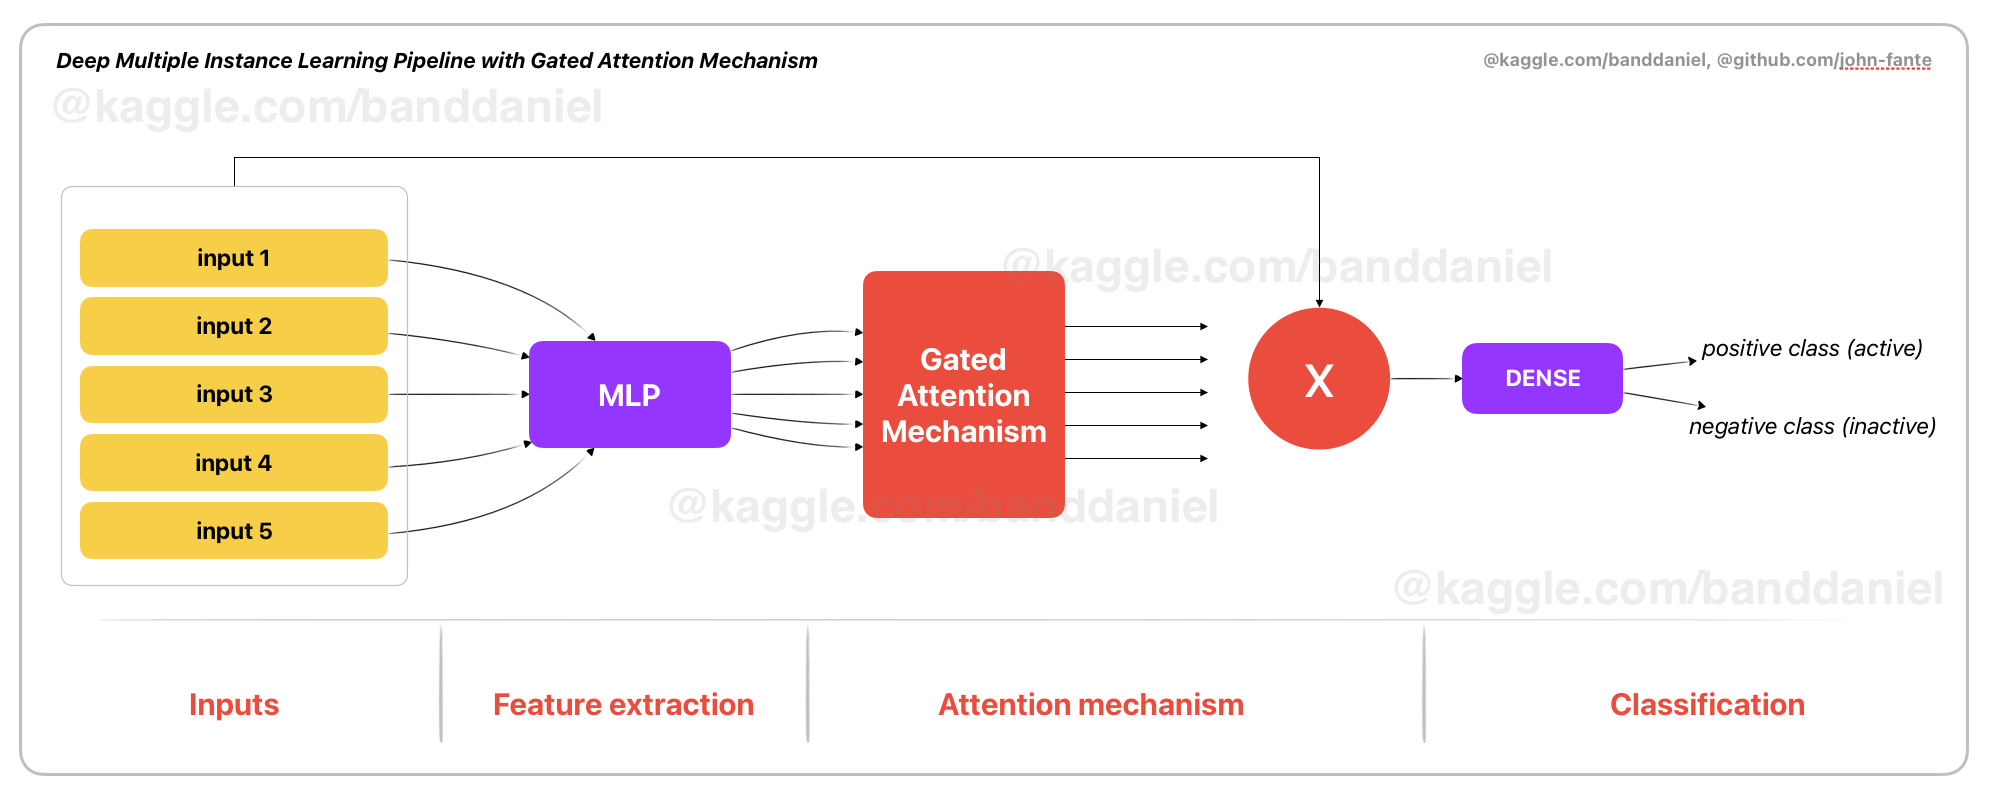
<i> <b>Figure 2:</b> Proposed Deep Multiple Instance Learning pipeline with gated attention [2]</i>


## My Another Projects
* [Satellite Image Captioning (ViT, Bi-LSTMs)](https://www.kaggle.com/code/banddaniel/satellite-image-captioning-vit-bi-lstms)
* [Mammals Classification w/Ensemble Deep Learning](https://www.kaggle.com/code/banddaniel/mammals-classification-w-ensemble-deep-learning)
* [Brain Tumor Detection w/Keras YOLO V8](https://www.kaggle.com/code/banddaniel/brain-tumor-detection-w-keras-yolo-v8)


## References
1. https://en.wikipedia.org/wiki/Multiple_instance_learning
2. Ilse, M., Tomczak, J. M., & Welling, M. (2018). Attention-based Deep Multiple Instance Learning (Version 4). arXiv. https://doi.org/10.48550/ARXIV.1802.04712
3. https://keras.io/examples/vision/attention_mil_classification/

In [1]:
# Importing dependencies

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, Multiply, concatenate
from tensorflow.keras.models import Model
from colorama import Fore, Back, Style
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import confusion_matrix,f1_score,log_loss, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import  StandardScaler

# <span style="color:#e74c3c;"> Reading </span> Data

In [2]:
train_data = pd.read_csv('/kaggle/input/musk-v2-multiple-instance-learning-data/musk2-10-proc1_ csv/nweka-musk2-10-7tra.csv')
test_data = pd.read_csv('/kaggle/input/musk-v2-multiple-instance-learning-data/musk2-10-proc1_ csv/nweka-musk2-10-7tst.csv')

train_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_data.drop(['Unnamed: 0'], axis = 1, inplace = True)

X_train = train_data.iloc[:,1:-1]
y_train = train_data['label'].values
train_molecul_names = train_data['molecul_name'].values

X_test = test_data.iloc[:,1:-1]
y_test = test_data['label'].values
test_molecul_names = test_data['molecul_name'].values

train_data.head()

,molecul_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f158,f159,f160,f161,f162,f163,f164,f165,f166,label
0,MUSK-jf67,51.0,-126.0,-24.0,-73.0,-117.0,76.0,-161.0,73.0,-237.0,...,-293.0,63.0,-13.0,-27.0,108.0,172.0,-44.0,-116.0,119.0,1
1,MUSK-jf67,44.0,-106.0,-20.0,-75.0,-117.0,84.0,-166.0,58.0,-232.0,...,-237.0,69.0,-9.0,150.0,128.0,160.0,-66.0,-145.0,-4.0,1
2,MUSK-jf67,37.0,-120.0,-132.0,34.0,-117.0,-100.0,61.0,-13.0,44.0,...,-194.0,-203.0,-9.0,23.0,111.0,195.0,-55.0,-149.0,112.0,1
3,MUSK-jf67,48.0,-187.0,-131.0,29.0,-117.0,-87.0,62.0,-6.0,38.0,...,-212.0,-207.0,14.0,155.0,131.0,188.0,-72.0,-173.0,12.0,1
4,MUSK-jf67,44.0,-101.0,-19.0,-47.0,-117.0,51.0,-168.0,58.0,-216.0,...,-71.0,64.0,-8.0,150.0,130.0,159.0,-66.0,-145.0,-5.0,1


# <span style="color:#e74c3c;"> Preprocessing </span>

In [3]:
# scaling data

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# a function for creating bags
def create_bags(data, label, molecul_names, positive_class, bag_size):
    bags = []
    bag_labels = []
    bag_mol_names = []
    total_bags = data.shape[0] // bag_size

    count = 0

    for _ in range(total_bags):
        idx = np.random.choice(data.shape[0], bag_size, replace=False)
        instances_data = data[idx]
        instances_labels = label[idx]
        mol_names = molecul_names[idx]

        bag_label = 0

        if positive_class in instances_labels:
            bag_label = 1
            count += 1

        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))
        bag_mol_names.append(mol_names)


    print(f"Positive bags: {count}")
    print(f"Negative bags: {total_bags - count}")
    print("-"*20)


    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels), bag_mol_names)


# ----------------------------
# a function for creating printing bags 
# GREEN -> a positive bag
# RED -> a negative bag

def print_bags(labels, molecul_names):
    idx = np.random.choice(len(molecul_names), 1, replace=False)[0]
    print("BAG NUMBER :" + str(idx))


    if labels[idx][0] == 1:
        print(Fore.GREEN + molecul_names[idx][0] + ", " + molecul_names[idx][1] +  ", " + molecul_names[idx][2]+  ", " + molecul_names[idx][3]+  ", " + molecul_names[idx][4])
    else:
        print(Fore.RED + molecul_names[idx][0] + ", " + molecul_names[idx][1] +  ", " + molecul_names[idx][2]+  ", " + molecul_names[idx][3]+  ", " + molecul_names[idx][4])

    print(Style.RESET_ALL)

# <span style="color:#e74c3c;"> Creating </span> Test Bags

In [5]:
test_bags, test_labels, test_mol_names = create_bags(X_test_scaled, y_test, test_molecul_names, 1, 5)

# GREEN -> a positive bag
# RED -> a negative bag

print_bags(test_labels, test_mol_names)
print_bags(test_labels, test_mol_names)
print_bags(test_labels, test_mol_names)

Positive bags: 71
Negative bags: 168
--------------------
BAG NUMBER :141
NON-MUSK-j146, NON-MUSK-j146, NON-MUSK-j146, NON-MUSK-j146, NON-MUSK-j146

BAG NUMBER :197
NON-MUSK-j146, NON-MUSK-j146, NON-MUSK-j146, NON-MUSK-j146, NON-MUSK-j146

BAG NUMBER :130
NON-MUSK-j146, NON-MUSK-j146, NON-MUSK-j146, NON-MUSK-j146, NON-MUSK-j146



# <span style="color:#e74c3c;"> MIL Gated </span> Attention Layer

In [6]:
class MIL_Attention(Layer):
    def __init__(self, weight_params_dim, kernel_initializer1="glorot_uniform", kernel_initializer2="glorot_uniform",
                 kernel_initializer3="glorot_uniform", kernel_regularizer=None, use_gated=False, **kwargs):

        super(MIL_Attention, self).__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer1 = keras.initializers.get(kernel_initializer1)
        self.kernel_initializer2 = keras.initializers.get(kernel_initializer2)
        self.kernel_initializer3 = keras.initializers.get(kernel_initializer3)

        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer1
        self.w_init = self.kernel_initializer2
        self.u_init = self.kernel_initializer3

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self,input_shape):
        input_dim = input_shape[0][1]
        self.v_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim), initializer=self.v_init, name="v",
                                               regularizer=self.v_regularizer, trainable=True)

        self.w_weight_params = self.add_weight(shape=(self.weight_params_dim, 1), initializer=self.w_init, name="w",
                                               regularizer=self.w_regularizer, trainable=True)

        if self.use_gated:
            self.u_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim), initializer=self.u_init, name="u",
                                                   regularizer=self.u_regularizer, trainable=True)
        else:
            self.u_weight_params = None
            self.input_built = True

    def call(self, inputs):
        instances = [self.compute_attention_scores(instance) for instance in inputs]
        instances = tf.stack(instances)
        alpha = tf.nn.softmax(instances, axis = 0)
        return [alpha[i] for i in range(alpha.shape[0])]


    def compute_attention_scores(self, instance):
        original_instance = instance
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))

        if self.use_gated:
            instance = instance * tf.math.sigmoid(tf.tensordot(original_instance,self.u_weight_params, axes=1 ))

        return tf.tensordot(instance, self.w_weight_params, axes = 1)
    
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                "weight_params_dim" : self.weight_params_dim,
                "kernel_initializer1" : self.kernel_initializer1,
                "kernel_initializer2" : self.kernel_initializer2,
                "kernel_initializer3" : self.kernel_initializer3,
                "kernel_regularizer" : self.kernel_regularizer,
                "use_gated" : self.use_gated}

# <span style="color:#e74c3c;"> Deep MIL </span> Model

In [7]:
def create_mil_model(dense1_units, dense2_units, dense3_units, weight_params_dim , mlp_dropout_rate = 0.2):
    dense1 = Dense(dense1_units, activation = 'relu')
    dense2 = Dense(dense2_units, activation = 'relu')
    dense3 = Dense(dense3_units, activation = 'relu')


    inp1 = Input(shape =(166))
    dense1_1 = dense1(inp1)
    dense1_1 = Dropout(mlp_dropout_rate)(dense1_1)
    dense1_2 = dense2(dense1_1)
    dense1_3 = dense3(dense1_2)

    inp2 = Input(shape =(166))
    dense2_1 = dense1(inp2)
    dense2_1 = Dropout(mlp_dropout_rate)(dense2_1)
    dense2_2 = dense2(dense2_1)
    dense2_3 = dense3(dense2_2)


    inp3 = Input(shape =(166))
    dense3_1 = dense1(inp3)
    dense3_1 = Dropout(mlp_dropout_rate)(dense3_1)
    dense3_2 = dense2(dense3_1)
    dense3_3 = dense3(dense3_2)

    inp4 = Input(shape =(166))
    dense4_1 = dense1(inp4)
    dense4_1 = Dropout(mlp_dropout_rate)(dense4_1)
    dense4_2 = dense2(dense4_1)
    dense4_3 = dense3(dense4_2)

    inp5 = Input(shape =(166))
    dense5_1 = dense1(inp5)
    dense5_1 = Dropout(mlp_dropout_rate)(dense5_1)
    dense5_2 = dense2(dense5_1)
    dense5_3 = dense3(dense5_2)


    attention = MIL_Attention(weight_params_dim = weight_params_dim, kernel_regularizer = keras.regularizers.L2(0.08),
                              use_gated=True, name="attention")([dense1_3, dense2_3, dense3_3, dense4_3, dense5_3])

    mult1 = Multiply()([attention[0], dense1_3])
    mult2 = Multiply()([attention[1], dense2_3])
    mult3 = Multiply()([attention[2], dense3_3])
    mult4 = Multiply()([attention[3], dense4_3])
    mult5 = Multiply()([attention[4], dense5_3])

    conc = concatenate([mult1, mult2,mult3,mult4,mult5])

    out = Dense(2, activation = 'softmax')(conc)

    model = Model(inputs = [inp1, inp2, inp3,inp4,inp5], outputs = out)
    
    model.compile(optimizer = tf.optimizers.SGD(learning_rate = 0.0005, weight_decay = 0.03, momentum = 0.9),
              loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    
    return model


# a custom callback for printing test prediction each 10 loop
class Test_Pred_During_Training(Callback):
    def __init__(self, model):
        self.model = model
        
    def on_epoch_end(self, epochs, logs = None ):
        try:
            if (epochs+1) % 10 == 0:
                pred = self.model.predict(test_bags, verbose = 0)
                pred = np.argmax(pred, axis = 1)

                test_eval = self.model.evaluate(test_bags, test_labels)
                f1 = f1_score(test_labels, pred)
                roc = roc_auc_score(test_labels, pred)
                print("--"*30)
                print("F1 Score: {0:.5f}".format(f1))
                print("ROC Score: {0:.5f}".format(roc))
                print("--"*30)
                
        except ValueError:
            pass

In [8]:
# training cross validation loop
def create_train_loop(loop_num):
    
    test_evals = []
    test_preds = []
    
    for i in range(loop_num):
        print("----------  Start Loop No: {0} ---------- ".format(i+1))
        
        # splitting train and validation data then creating bags
        print("\n---------- Created Bags (Train, Valid) ----------")
        split_idx = 500
        train_bags, train_labels, train_mol_names = create_bags(X_train_scaled[split_idx:], y_train[split_idx:], train_molecul_names[split_idx:], 1, 5)
        valid_bags, valid_labels, valid_mol_names = create_bags(X_train_scaled[:split_idx], y_train[:split_idx], train_molecul_names[:split_idx], 1, 5)
        
        
        # creating the model
        mil_model = create_mil_model(dense1_units = 128, dense2_units = 64, dense3_units = 32, weight_params_dim = 16, mlp_dropout_rate=0.2)
        
        my_callbacks = [Test_Pred_During_Training(mil_model), tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01,patience=15),
                        tf.keras.callbacks.ModelCheckpoint("/kaggle/working/mil_deep.{0}_loop_weights.h5".format(i+1), 
                                                           monitor="val_loss",mode="min", save_best_only=True, verbose=1)]
        
        # training
        hist = mil_model.fit(train_bags, train_labels, batch_size = 1, epochs = 70,
                         validation_data = (valid_bags, valid_labels),callbacks = my_callbacks ) 
        
        # test evaluation and prediction
        test_eval = mil_model.evaluate(test_bags, test_labels)
        pred = mil_model.predict(test_bags, verbose = 0)
        
        test_evals.append(test_eval)
        test_preds.append(pred)
        
        
    return test_evals, test_preds


# <span style="color:#e74c3c;"> Training </span>

In [9]:
test_evals, test_preds = create_train_loop(3)

----------  Start Loop No: 1 ---------- 

---------- Created Bags (Train, Valid) ----------
Positive bags: 584
Negative bags: 396
--------------------
Positive bags: 70
Negative bags: 30
--------------------
Epoch 1/70
973/980 [============================>.] - ETA: 0s - loss: 2.5971 - acc: 0.5868
Epoch 1: val_loss improved from inf to 1.40049, saving model to /kaggle/working/mil_deep.1_loop_weights.h5
980/980 [==============================] - 8s 6ms/step - loss: 2.5890 - acc: 0.5867 - val_loss: 1.4005 - val_acc: 0.7000
Epoch 2/70
971/980 [============================>.] - ETA: 0s - loss: 1.0366 - acc: 0.6107
Epoch 2: val_loss improved from 1.40049 to 0.77342, saving model to /kaggle/working/mil_deep.1_loop_weights.h5
980/980 [==============================] - 5s 5ms/step - loss: 1.0349 - acc: 0.6102 - val_loss: 0.7734 - val_acc: 0.7000
Epoch 3/70
972/980 [============================>.] - ETA: 0s - loss: 0.6908 - acc: 0.6317
Epoch 3: val_loss improved from 0.77342 to 0.66352, saving 

# <span style="color:#e74c3c;"> Test </span> Predictions

In [10]:
pred_ = np.mean(test_preds, axis = 0)
pred = np.argmax(pred_, axis = 1)

f1 = f1_score(test_labels, pred)
roc = roc_auc_score(test_labels, pred)

print("F1 Score: {0:.5f}".format(f1))
print("ROC Score: {0:.5f}".format(roc))

F1 Score: 0.89032
ROC Score: 0.94127


# <span style="color:#e74c3c;"> Classification </span> Report

In [11]:
clf = classification_report(test_labels, pred)
print(clf)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       168
           1       0.82      0.97      0.89        71

    accuracy                           0.93       239
   macro avg       0.90      0.94      0.92       239
weighted avg       0.94      0.93      0.93       239



# <span style="color:#e74c3c;"> Confusion </span> Matrix

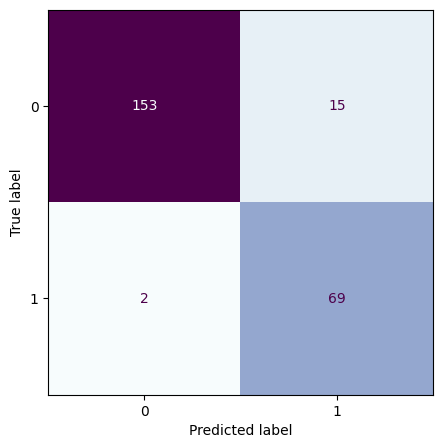

In [12]:
cm = confusion_matrix(test_labels, pred)
cmd = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

# <span style="color:#e74c3c;"> Attention </span> Performance

In [13]:
def print_attention_score(model, data,label, molecul_names, SEED = None):
    idx = np.random.default_rng(seed=SEED).permutation(len(molecul_names))[0]


    print("BAG NUMBER : " + str(idx) + ", BAG LABEL : " +str(label[idx]) )

    intermediate_model = keras.Model(model.input, model.get_layer("attention").output)
    intermediate_predictions = intermediate_model.predict(data, verbose = 0)
    attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))

    mol_names = [molecul_names[idx][0], molecul_names[idx][1], molecul_names[idx][2], molecul_names[idx][3], molecul_names[idx][4] ]
    att = [attention_weights[idx][0], attention_weights[idx][1], attention_weights[idx][2], attention_weights[idx][3], attention_weights[idx][4]]

    df = pd.DataFrame({'molecul names': mol_names, 'attention weight': att})

    print(Fore.RED , df)
    print(Style.RESET_ALL)

In [14]:
# loading weights of 3rd model
# It is an overt fact that positive classes have a higher attention score.

model = create_mil_model(dense1_units = 128, dense2_units = 64, dense3_units = 32, weight_params_dim = 16, mlp_dropout_rate=0.2)
model.load_weights('/kaggle/working/mil_deep.3_loop_weights.h5')

print_attention_score(model, test_bags,test_labels, test_mol_names, SEED = 3)
print_attention_score(model, test_bags,test_labels, test_mol_names, SEED = 49)
print_attention_score(model, test_bags,test_labels, test_mol_names, SEED = 4876)

BAG NUMBER : 23, BAG LABEL : [0]
    molecul names  attention weight
0  NON-MUSK-j100          0.199477
1  NON-MUSK-j146          0.207290
2  NON-MUSK-j146          0.193788
3  NON-MUSK-j146          0.202449
4  NON-MUSK-j146          0.196997

BAG NUMBER : 184, BAG LABEL : [0]
    molecul names  attention weight
0  NON-MUSK-j146          0.195233
1  NON-MUSK-j146          0.198194
2  NON-MUSK-j146          0.203101
3  NON-MUSK-j146          0.202070
4  NON-MUSK-j146          0.201402

BAG NUMBER : 134, BAG LABEL : [0]
    molecul names  attention weight
0  NON-MUSK-j146          0.197911
1  NON-MUSK-j146          0.200089
2  NON-MUSK-j146          0.202473
3  NON-MUSK-j146          0.194980
4  NON-MUSK-j146          0.204546

